# Deep Residual Learning for Image Recognition: CIFAR-10 

This notebook provides a PyTorch implementation of *Deep Residual Learning for Image Recogniton* by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Han Sun which achived state of the art in 2015 by winning the ILSVRC and COCO challenges.

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

from resnet import ResNet
from data_loader import get_data_loaders, plot_images
from utils import calculate_normalisation_params
from train import train


import warnings
warnings.filterwarnings('ignore')

In [4]:
# GLOBALS
# -----------------------

data_dir = 'data/cifar10'
batch_size = 128

## Data augmentation: Training set

Files already downloaded and verified
Files already downloaded and verified


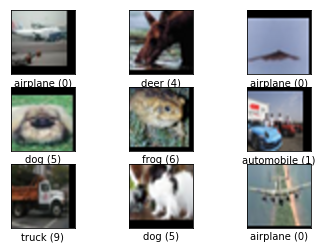

torch.Size([128, 3, 32, 32])


In [4]:
# VISUALISE
# -----------------------

# Load data without normalisations

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor()
])

train_loader, test_loader = get_data_loaders(data_dir,
                                             batch_size,
                                             train_transform,
                                             test_transform,
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True)


# Training images
data_iter = iter(train_loader)
images, labels = data_iter.next()
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)
print(images.shape)

The training set consists of 50,000 32x32 pixel images. These are padded with 4 pixels on each side, before a crop is randomly sampled from the padded image or its horziontal flip. 

The authors cite C.-Y. Lee, S. Xie, P. Gallagher, Z. Zhang, and Z. Tu. Deeply-supervised nets. arXiv:1409.5185, 2014. This paper suggests that 'corner cropping' should be used which could be interpretted one of two ways:

1. There are five possible crops for each image, centre and then four further crops with the crop placed tightly in each corner. This equates to `torchvision.transforms.FiveCrop()` in PyTorch.
2. The crop position is randomly selected from any possible position within the bounds of the padded image. Equivalent to `torchvision.transforms.RandomCrop()` in PyTorch.

The intended implementation seem ambiguous to me, so I implemented the latter here largely for simplicity.

## Data augmentation: Test set

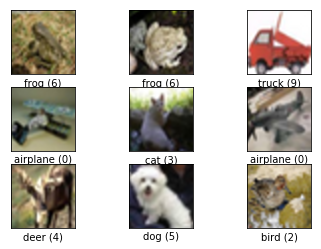

torch.Size([128, 3, 32, 32])


In [5]:
# Test images
data_iter = iter(test_loader)
images, labels = data_iter.next()
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)
print(images.shape)

There are 10,000 images in the test set. These are not transformed.

## Calculate normalisation parameters

The authors don't explicitly state if the images are normalised prior to training, however the paper referenced on preprocessing (C.-Y. Lee, S. Xie, P. Gallagher, Z. Zhang, and Z. Tu. Deeply-supervised nets. arXiv:1409.5185, 2014) notes that normalisation is used. 

I was unsure if the mean and standard deviation of the dataset should be calculated before or after augmentation for this purpose. It is also unclear if these calcualations should be done across the training and test set combined, or only the training set.

Her I've used the pre-transform training and test set combined.

In [6]:
# NORMALIZATION
# -----------------------
# Calculate the mean and standard deviation of each channel
# for all observations in training and test datasets. The
# results can then be used for normalisation

# Load data without transforms
if False:
    train_transform = transforms.Compose([
        # 4 pixels are padded on each side, 
        transforms.ToTensor()
    ])

    test_transform = transforms.Compose([
        # For testing, we only evaluate the single 
        # view of the original 32×32 image.
        transforms.ToTensor()
    ])

    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)


    # Takes a while to run so I've hardcoded results below

    means, stds = calculate_normalisation_params(train_loader, test_loader)
    print(f'means: {means}')
    print(f'stds: {stds}')

Files already downloaded and verified
Files already downloaded and verified
means: [0.491868790120092, 0.491858596032074, 0.4918525181999997]
stds: [0.24697121702735958, 0.2469687055589789, 0.24697312060570947]


## Preprocessing

Here we finalise data augmentation and normalisation parameters ahead of training.

In [6]:
# SET FINAL TRANSFORMS WITH NORMALISATION

# [x] simple data augmentation in [24]
# [x] 4 pixels are padded on each side, 
# [x] and a 32×32 crop is randomly sampled from the padded image or its horizontal flip.
# [x] For testing, we only evaluate the single view of the original 32×32 image.


# Normalisation parameters fo CIFAR10
means = [0.4918687901200927, 0.49185976472299225, 0.4918583862227116]
stds  = [0.24697121702736, 0.24696766978537033, 0.2469719877121087]

normalize = transforms.Normalize(
    mean=means,
    std=stds,
)

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor(),
    normalize
])

Notes:

- Note: downsampling with stride 2 results in uneven convolution, e.g. W_out is 16.5. Why didn't the authors use Maxpooling, would have been neater.

## Training

The authors report their results in term of training iterations. I've assumed an iteration here means a forwards and backwards pass of a batch of 128 observations through the entire network.

It seems more convenient to work in epochs in PyTorch, so here I calculate the integer number of iterations per epoch for later conversions. The results is 391 iterations per epoch. An epoch is a forwards and backwards pass for all observations in the training set.

In [7]:
# How many iterations in an epoch?

iterations = 0
for i, data in enumerate(train_loader, 0):
    iterations +=1
print(iterations)

391


### Hyperparameters

Set the hyperparameters as described by the authors, with iterations converted to epochs where appropriate.

In [8]:
# TRAINING PARAMETERS
# -------------------------

# Authors cite 64k iterations
# 64000/391 = 164
epochs = 164

# OPTIMISER PARAMETERS
lr = 0.1 # authors cite 0.1
momentum = 0.9
weight_decay = 0.0001 

# LEARNING RATE ADJUSTMENT
# Reduce learning rate at iterations 
# 32k and 48k. Convert to epochs:
# e.g. iterations / (n_observations/batch_size) 
# 32000/391 = 82
# 48000/391 = 123
milestones = [82, 123]
# Divide learning rate by 10 at each milestone
gamma = 0.1

### Plain nets

Run training loop for **'plain' convolutional networks** without shortcuts. Here we run for n={3, 5, 7,9} corresponding to networks of depth 20, 32, 44 and 64 layers. 

In [9]:
%%time
# TRAIN PLAIN NETs

# n determines network size as described in paper
# where total number of layers is (6*n)+2
ns = [3, ]
# ns = [3, 5, 7, 9, 18]
# Train plainnets
for n in ns:
    print(f'MODEL SIZE: n={n}')
    # Reload data
    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)
    
    model = ResNet(n, shortcuts=False)
    criterion = torch.nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    results_file = f'results/plainnet{6*n+2}.csv'
    model_file = f'pretrained/plainnet{6*n+2}.pt'
    train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

MODEL SIZE: n=3
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Epoch 	Batch 	NLLLoss_Train
1 	50 	2.090
1 	100 	1.877
1 	150 	1.809
1 	200 	1.730
1 	250 	1.722
1 	300 	1.676
1 	350 	1.642
train_err: 0.59346 test_err: 0.5876
2 	50 	1.557
2 	100 	1.484
2 	150 	1.447
2 	200 	1.401
2 	250 	1.371
2 	300 	1.369
2 	350 	1.248
train_err: 0.4735 test_err: 0.4744
3 	50 	1.200
3 	100 	1.163
3 	150 	1.136
3 	200 	1.086
3 	250 	1.053
3 	300 	1.059
3 	350 	1.013
train_err: 0.47406 test_err: 0.4884
4 	50 	0.940
4 	100 	0.926
4 	150 	0.900
4 	200 	0.922
4 	250 	0.884
4 	300 	0.912
4 	350 	0.876
train_err: 0.357 test_err: 0.3579
5 	50 	0.806
5 	100 	0.826
5 	150 	0.826
5 	200 	0.797
5 	250 	0.760
5 	300 	0.806
5 	350 	0.742
train_err: 0.3204 test_err: 0.3232
6 	50 	0.733
6 	100 	0.719
6 	150 	0.737
6 	200 	0.717
6 	250 	0.715
6 	300 	0.727
6 	350 	0.708
train_err: 0.2675 test_err: 0.2735
7 	50 	0.685
7 	100 	0.668
7 	150 	0.694
7 	200 	0.668
7 	250 	0.677
7 	300 	0.6

59 	150 	0.321
59 	200 	0.303
59 	250 	0.320
59 	300 	0.306
59 	350 	0.330
train_err: 0.13612 test_err: 0.1705
60 	50 	0.281
60 	100 	0.319
60 	150 	0.312
60 	200 	0.300
60 	250 	0.304
60 	300 	0.320
60 	350 	0.307
train_err: 0.12514 test_err: 0.1621
61 	50 	0.305
61 	100 	0.317
61 	150 	0.285
61 	200 	0.308
61 	250 	0.339
61 	300 	0.300
61 	350 	0.305
train_err: 0.123 test_err: 0.1625
62 	50 	0.284
62 	100 	0.301
62 	150 	0.314
62 	200 	0.303
62 	250 	0.325
62 	300 	0.309
62 	350 	0.319
train_err: 0.14802 test_err: 0.187
63 	50 	0.297
63 	100 	0.289
63 	150 	0.284
63 	200 	0.308
63 	250 	0.300
63 	300 	0.314
63 	350 	0.303
train_err: 0.12682 test_err: 0.161
64 	50 	0.313
64 	100 	0.298
64 	150 	0.302
64 	200 	0.306
64 	250 	0.296
64 	300 	0.314
64 	350 	0.296
train_err: 0.13386 test_err: 0.1692
65 	50 	0.290
65 	100 	0.269
65 	150 	0.306
65 	200 	0.305
65 	250 	0.316
65 	300 	0.291
65 	350 	0.315
train_err: 0.12406 test_err: 0.1641
66 	50 	0.289
66 	100 	0.286
66 	150 	0.300
66 	200 	

117 	100 	0.062
117 	150 	0.067
117 	200 	0.065
117 	250 	0.074
117 	300 	0.067
117 	350 	0.068
train_err: 0.01822 test_err: 0.1002
118 	50 	0.064
118 	100 	0.061
118 	150 	0.061
118 	200 	0.064
118 	250 	0.062
118 	300 	0.067
118 	350 	0.062
train_err: 0.01834 test_err: 0.1042
119 	50 	0.059
119 	100 	0.066
119 	150 	0.063
119 	200 	0.062
119 	250 	0.065
119 	300 	0.069
119 	350 	0.073
train_err: 0.01604 test_err: 0.1017
120 	50 	0.063
120 	100 	0.066
120 	150 	0.064
120 	200 	0.061
120 	250 	0.065
120 	300 	0.064
120 	350 	0.067
train_err: 0.01666 test_err: 0.1045
121 	50 	0.061
121 	100 	0.076
121 	150 	0.071
121 	200 	0.064
121 	250 	0.062
121 	300 	0.079
121 	350 	0.069
train_err: 0.0169 test_err: 0.1031
122 	50 	0.051
122 	100 	0.064
122 	150 	0.053
122 	200 	0.061
122 	250 	0.059
122 	300 	0.060
122 	350 	0.062
train_err: 0.01798 test_err: 0.1032
123 	50 	0.066
123 	100 	0.065
123 	150 	0.061
123 	200 	0.067
123 	250 	0.065
123 	300 	0.061
123 	350 	0.058
train_err: 0.01604 test

### Residual nets

Run training loop for residual networks with shortcuts. Here we run for n={3, 5, 7,9} corresponding to networks of depth 20, 32, 44 and 64 layers.


In [9]:
%%time

# TRAIN RESNETs

# n determines network size as described in paper
# ns = [3, 5, 7, 9]
ns = [18, ]
# Train resnets
for n in ns:
    print(f'MODEL SIZE: n={n}')
    # Reload data
    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)
    
    model = ResNet(n, shortcuts=True)
    criterion = torch.nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    results_file = f'results/resnet{6*n+2}.csv'
    model_file = f'pretrained/resnet{6*n+2}.pt'
    train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

MODEL SIZE: n=18
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Epoch 	Batch 	NLLLoss_Train
1 	50 	4.147
1 	100 	2.303
1 	150 	2.299
1 	200 	2.300
1 	250 	2.297
1 	300 	2.276
1 	350 	2.243
train_err: 0.82912 test_err: 0.8218
2 	50 	2.093
2 	100 	2.005
2 	150 	1.915
2 	200 	1.822
2 	250 	1.787
2 	300 	1.766
2 	350 	1.702
train_err: 0.62636 test_err: 0.6079
3 	50 	1.595
3 	100 	1.575
3 	150 	1.552
3 	200 	1.466
3 	250 	1.407
3 	300 	1.362
3 	350 	1.347
train_err: 0.50672 test_err: 0.5003
4 	50 	1.293
4 	100 	1.248
4 	150 	1.222
4 	200 	1.170
4 	250 	1.149
4 	300 	1.140
4 	350 	1.104
train_err: 0.4037 test_err: 0.3936
5 	50 	1.076
5 	100 	1.057
5 	150 	1.031
5 	200 	1.061
5 	250 	1.020
5 	300 	0.997
5 	350 	0.975
train_err: 0.3754 test_err: 0.3691
6 	50 	0.933
6 	100 	0.937
6 	150 	0.954
6 	200 	0.921
6 	250 	0.927
6 	300 	0.912
6 	350 	0.886
train_err: 0.3362 test_err: 0.3635
7 	50 	0.863
7 	100 	0.871
7 	150 	0.874
7 	200 	0.857
7 	250 	0.859
7 	300 	

59 	200 	0.237
59 	250 	0.226
59 	300 	0.243
59 	350 	0.213
train_err: 0.07596 test_err: 0.1268
60 	50 	0.190
60 	100 	0.218
60 	150 	0.201
60 	200 	0.209
60 	250 	0.221
60 	300 	0.241
60 	350 	0.214
train_err: 0.08714 test_err: 0.1472
61 	50 	0.200
61 	100 	0.199
61 	150 	0.225
61 	200 	0.243
61 	250 	0.232
61 	300 	0.222
61 	350 	0.246
train_err: 0.07316 test_err: 0.1244
62 	50 	0.191
62 	100 	0.191
62 	150 	0.219
62 	200 	0.245
62 	250 	0.225
62 	300 	0.229
62 	350 	0.235
train_err: 0.15442 test_err: 0.205
63 	50 	0.210
63 	100 	0.203
63 	150 	0.217
63 	200 	0.229
63 	250 	0.211
63 	300 	0.224
63 	350 	0.197
train_err: 0.0965 test_err: 0.1544
64 	50 	0.193
64 	100 	0.204
64 	150 	0.199
64 	200 	0.217
64 	250 	0.213
64 	300 	0.223
64 	350 	0.221
train_err: 0.08336 test_err: 0.142
65 	50 	0.195
65 	100 	0.210
65 	150 	0.185
65 	200 	0.211
65 	250 	0.225
65 	300 	0.214
65 	350 	0.199
train_err: 0.09814 test_err: 0.1505
66 	50 	0.192
66 	100 	0.201
66 	150 	0.208
66 	200 	0.196
66 	250 

117 	150 	0.008
117 	200 	0.011
117 	250 	0.009
117 	300 	0.010
117 	350 	0.008
train_err: 0.00112 test_err: 0.0828
118 	50 	0.009
118 	100 	0.009
118 	150 	0.008
118 	200 	0.011
118 	250 	0.009
118 	300 	0.009
118 	350 	0.010
train_err: 0.00144 test_err: 0.0794
119 	50 	0.008
119 	100 	0.009
119 	150 	0.009
119 	200 	0.007
119 	250 	0.010
119 	300 	0.011
119 	350 	0.010
train_err: 0.0015 test_err: 0.0791
120 	50 	0.008
120 	100 	0.008
120 	150 	0.009
120 	200 	0.009
120 	250 	0.011
120 	300 	0.007
120 	350 	0.010
train_err: 0.0016 test_err: 0.0792
121 	50 	0.009
121 	100 	0.011
121 	150 	0.008
121 	200 	0.009
121 	250 	0.006
121 	300 	0.009
121 	350 	0.008
train_err: 0.00154 test_err: 0.0773
122 	50 	0.009
122 	100 	0.006
122 	150 	0.009
122 	200 	0.010
122 	250 	0.009
122 	300 	0.009
122 	350 	0.009
train_err: 0.00168 test_err: 0.0775
123 	50 	0.007
123 	100 	0.006
123 	150 	0.008
123 	200 	0.008
123 	250 	0.009
123 	300 	0.007
123 	350 	0.008
train_err: 0.00102 test_err: 0.0783
124 

### Check model

Table 6. in the paper reports that the ResNet model with 20 layers should have 0.27 million trainable parameters. We reproduce that here.

It is noted elsewhere that the plain net should have the same number of parameters for the CIFAR10 experiment. This is because an identity mapping is used for the residual shortcuts, as opposed to a convolutional layer, an so there are no additional trainable parameters.

In [ ]:
print(f'Parameter count: {sum([p.numel() for p in model.parameters()])}')

The PyTorch model architecture for a 20 layer model.

In [ ]:
print(model)

## Analysis

### Plain net

First we compare the performance of 'plain' convolutional networks of various depths. This corresponds to the left-hand axis of Figure. 6 in the paper. 

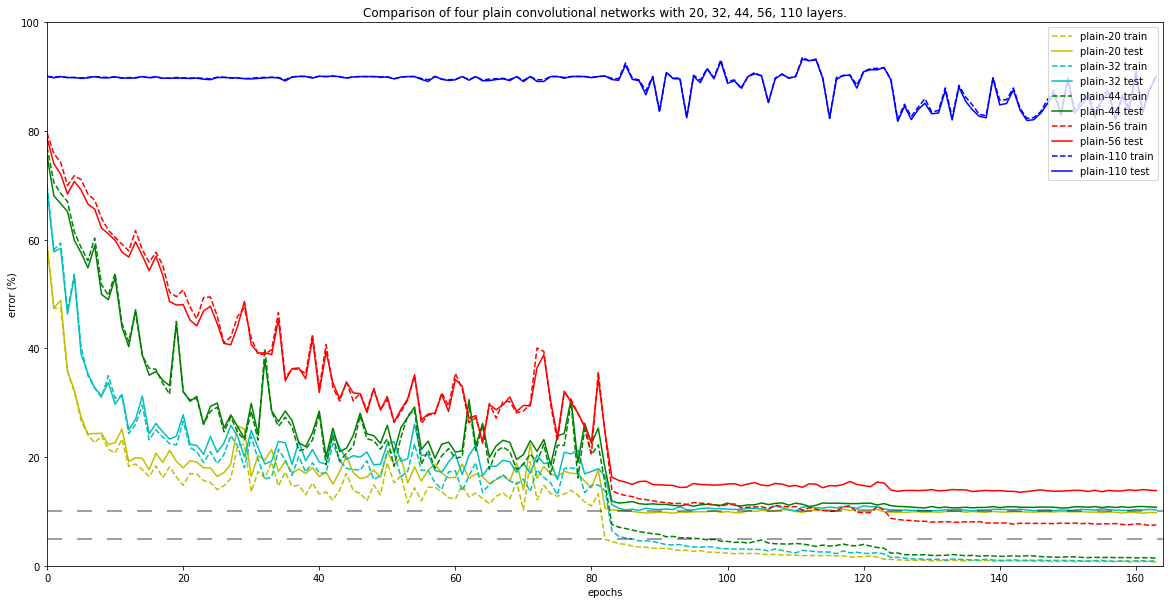

In [5]:
# ns  = [3, 5, 7, 9]
ns = [3, 5, 7, 9, 18]
clr = ['y', 'c', 'g', 'r', 'b']


plainnet_dfs = [pd.read_csv(f'results/plainnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 164, 0, 100])


for i in range(len(ns)):
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'plain-{6*ns[i]+2} train')
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'plain-{6*ns[i]+2} test')

plt.title('Comparison of four plain convolutional networks with 20, 32, 44, 56, 110 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));

In [6]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in plainnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = ['PlainNet20', 'PlainNet32', 'PlainNet44', 'PlainNet56', 'PlainNet110']
display(bests_df[['model', 'test_err']])

,model,test_err
92,PlainNet20,0.0968
110,PlainNet32,0.1011
149,PlainNet44,0.1063
143,PlainNet56,0.1354
125,PlainNet110,0.8175


### Resnet

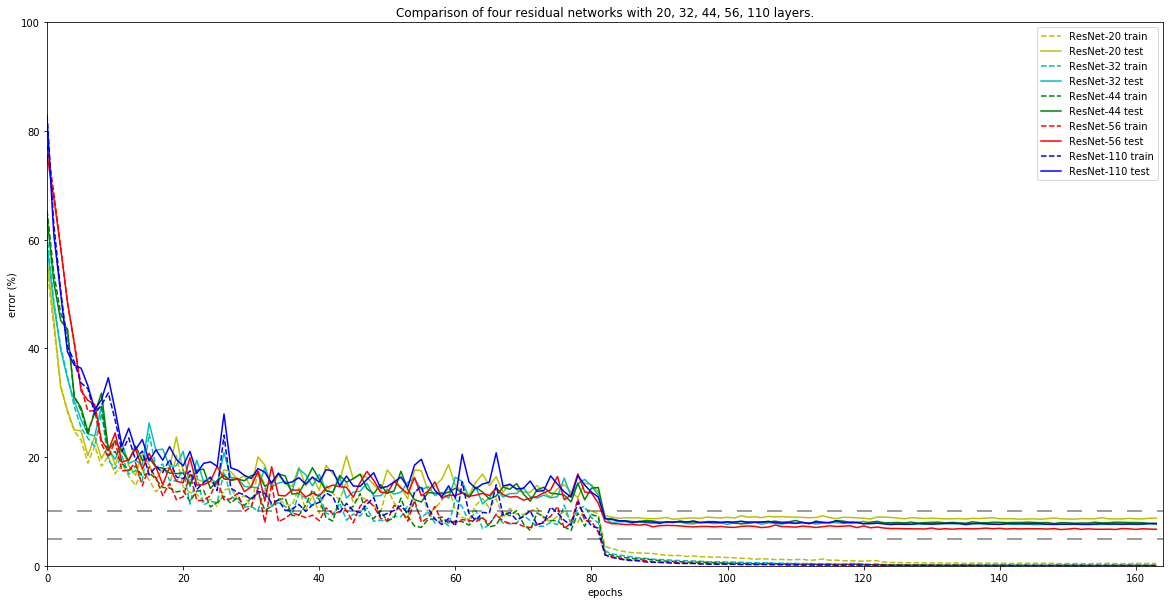

In [7]:
# ns  = [3, 5, 7, 9]
# clr = ['y', 'c', 'g', 'r']

ns = [3, 5, 7, 9, 18]
clr = ['y', 'c', 'g', 'r', 'b']

resnet_dfs = [pd.read_csv(f'results/resnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 164, 0, 100])


for i in range(len(ns)):
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'ResNet-{6*ns[i]+2} train')
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'ResNet-{6*ns[i]+2} test')

plt.title('Comparison of four residual networks with 20, 32, 44, 56, 110 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));

In [8]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in resnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = ['ResNet20', 'ResNet32', 'ResNet44', 'ResNet56', 'ResNet110']
display(bests_df[['model', 'test_err']])


,model,test_err
92,ResNet20,0.0856
145,ResNet32,0.0757
112,ResNet44,0.0771
149,ResNet56,0.0667
135,ResNet110,0.0758


## Side-by-side plot

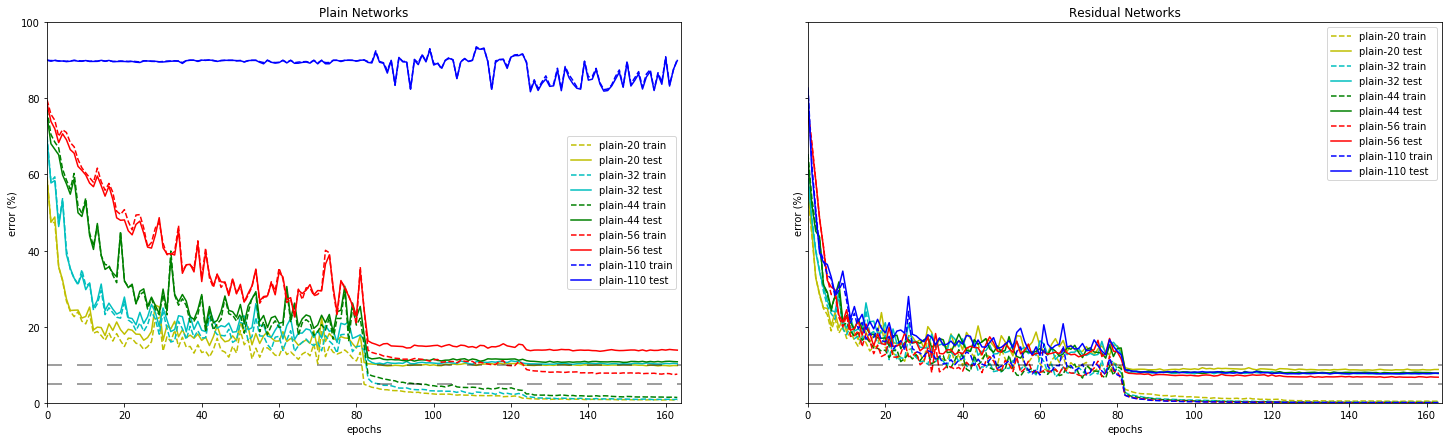

In [9]:
# ns  = [3, 5, 7, 9]
# clr = ['y', 'c', 'g', 'r']

ns = [3, 5, 7, 9, 18]
clr = ['y', 'c', 'g', 'r', 'b']

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 7))

plainnet_dfs = [pd.read_csv(f'results/plainnet{6*n+2}.csv') for n in ns]
resnet_dfs = [pd.read_csv(f'results/resnet{6*n+2}.csv') for n in ns]

def plot_results(dfs, ax, title):
    ax.axis([0, 164, 0, 100])
    
    for i in range(len(ns)):
        ax.plot(dfs[i]['epoch'], dfs[i]['train_err']*100, f'{clr[i]}--',
                 label=f'plain-{6*ns[i]+2} train')
        ax.plot(dfs[i]['epoch'], dfs[i]['test_err']*100, f'{clr[i]}',
                 label=f'plain-{6*ns[i]+2} test')
    
    ax.set_title(title)
    ax.legend(loc='bottom left')
    ax.set_xlabel('epochs')
    ax.set_ylabel('error (%)')
    ax.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
    ax.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));
    
plot_results(plainnet_dfs, ax1, 'Plain Networks')
plot_results(resnet_dfs, ax2, 'Residual Networks')